In [1]:
import sys

assert sys.version_info >= (3, 8), "This project requires Python 3.8+"

In [2]:
from packaging import version
import torch

In [3]:
assert version.parse(torch.__version__) >= version.parse("2.1.2"), "This project requires pytorch 2.1.1 or above!"

In [4]:
# src: https://youtu.be/lS0vvIWiahU
try:
    import google.colab

    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available
device = (
    "mps"
    if torch.backends.mps.is_built()
    else "cuda"
    if torch.backends.cuda.is_built()
    else "cpu"
)

print (f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


In [39]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [40]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.random.manual_seed(42)

## Data sets and Data Loader

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets

In [41]:
from torch.utils.data import random_split

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=ToTensor())
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=ToTensor())

train_ds, val_ds = random_split(train_dataset, [50000, 10000])

In [42]:
print("train+val size: ", train_dataset.data.shape)
print("test size: ", test_ds.data.shape)

train+val size:  torch.Size([60000, 28, 28])
test size:  torch.Size([10000, 28, 28])


In [43]:
# Hyper parameters
input_size = [*train_dataset.data.shape[1:]]
number_epochs = 10
batch_size = 32
learning_rate = 0.01

In [44]:
# Iterable object generated by DataLoader
train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_ds, batch_size=batch_size) # Doesn't have to get shuffled

In [45]:
# - DataLoader makes iterable object out of DataSets
#   - the iterable (`getitem` dunder) will return both _data_ and the corresponding _label_
data, label = next(iter(train_dloader))
print("Data:\t", data.size())
print("Label:\t", label.size())

Data:	 torch.Size([32, 1, 28, 28])
Label:	 torch.Size([32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 123.09it/s]


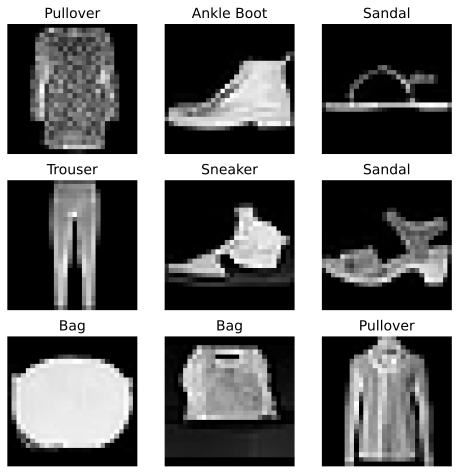

In [48]:
# Q: How do we know this is the correct map?
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in tqdm(range(1, cols * rows + 1)):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]  # img is our data
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  # Q: What does squeeze do?
plt.show()

In [49]:
class NN(nn.Module):
    def __init__(self, in_feature: int, output_feature: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_feature, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, output_feature)
